# Распознавание шрифтов 

## Описание проекта

Задача - распознавание шрифтов.

Цель - создание утилиты, которая принимает на вход изображение с текстом и распознает шрифт текста.

В папке fonts лежат шрифты для латинского алфавита. Шрифты были подобраны так, чтобы между ними было достаточно много различий.
Необходимо:

1.  Сгенерировать обучающую и тестовую выборки на основании шрифтов с помощью ЯП Python. 
    Можно использовать открытые библиотеки для генерации выборок. 
    В выборке должны присутствовать изображения всех шрифтов.
    Тексты должны быть на английском языке, тематика может быть любой (хоть случайная строка)
2.  Реализовать небольшое приложение для распознавания шрифтов

Приложение состоит из двух частей: модуль для обучения нейросети и модуль распознавания.

Модуль обучения:
1.  Содержит код нейросети
2.  Принимает на вход обучающую и тестовую выборки
3.  Обучает нейросеть, логгирует значения функции ошибки на обучающей и тестовой выборке. Логгировать можно любым образом (даже в txt или csv), главное чтобы
    можно было прочитать файл и отрисовать графики
4.  Оценивает основные метрики классификации, 
5.  Отрисовывает кривые обучающей и тестовой ошибок

Модуль обучения может быть либо консольным приложением, либо Jupyter-ноутбуком

Модуль распознавания является консольным приложением и принимает на вход путь до чекпойнта модели 
(или других служебных файлов) и возвращает название самого вероятного шрифта и его вероятность в консоль.

Для реализации используйте либо виртуальную среду virtualenv, либо Docker (желательно) для избежания конфликтов версий библиотек.

## План работы

1. Проведем подоготовку данных и создадим выборку изображений шрифтов.
2. Обучим нейронную сеть и рассчитаем её качество.
3. Создадим модуль распознования шрифта.

## Часть 1. Подоготовка данных и создание выборки изображений шрифтов.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from PIL import Image, ImageFilter

**Предоставленный список шрифтов расположен в файле `fonts_sample.csv`. Извлечем данные и выведем этот список.**

In [2]:
fonts_sample = pd.read_csv('fonts_sample.csv')

In [3]:
fonts_sample = fonts_sample['Font'].tolist()

In [4]:
print('\u001b[38;5;19m', 'Выведем список используемых шрифтов:', '\u001b[0m')
for i in sorted(fonts_sample):
    print('\u001b[38;5;19m', i, '\u001b[0m')

 Выведем список используемых шрифтов: 
 Aguante 
 Alumni Sans Collegiate One Italic 
 Alumni Sans Collegiate One Regular 
 Ambidexter 
 Aref Ruqaa Ink Bold 
 Aref Ruqaa Ink Regular 
 BRASS MONO Bold 
 BRASS MONO Bold Italic 
 BRASS MONO Bold Regular 
 BRASS MONO Italic 
 Better VCR 5.2 
 Ganesha Type Regular 
 Ghastly Panic 
 Realest Extended 
 Tana Uncial SP 


**Прилагаемые материалы полученные в формате `PDF`необходимо было обработать. Используя программное средство `Adobe Acrobat Reader` и `Paint`, изолировал символы латинского алфавита и сохранили в формате `JPG` с разрешением 1200 на 1200 точек на дюйм. Исходные отредактированные файлы были расположены в папке `fonts`.**

In [5]:
df_fonts = pd.DataFrame(columns=['Letter', 'Font'])

In [6]:
i = 0
def sample(f):
    
    img = cv2.imdecode(np.fromfile('fonts/'+str(f)+'.jpg', dtype=np.uint8), 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=70)
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    sharp_filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    img_sharpen = cv2.filter2D(thresh, ddepth=-1, kernel=sharp_filter)    
    output = img.copy()
    
    out_size=512
    global i
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
    
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 20)
            letter_crop = img_sharpen[y:y + h, x:x + w]
    
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
    
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop

            i += 1
            df_fonts.loc[len(df_fonts.index)] = [str(i)+'.jpg', f]
            letter_square = cv2.filter2D(letter_square, ddepth=-1, kernel=sharp_filter)
            cv2.imwrite('fonts_sample_img/'+str(i)+'.jpg', letter_square)
            letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
            
    fig = plt.figure(figsize=(20, 10)) 
    plt.imshow(output, cmap='gray')
    plt.axis('off')
    plt.show()                       
    letters.sort(key=lambda x: x[0], reverse=False)
    return letters

In [7]:
def letters_sample(letters):
    fig = plt.figure(figsize=(16, 7)) 
    rows = 1
    columns = 8
    for p in range(8):
        fig.add_subplot(rows, columns, p+1) 
        plt.imshow(letters[random.randint(1, 30)][2], cmap='gray')
        plt.axis('off')
    plt.show()

 Название шрифта:  Aguante 


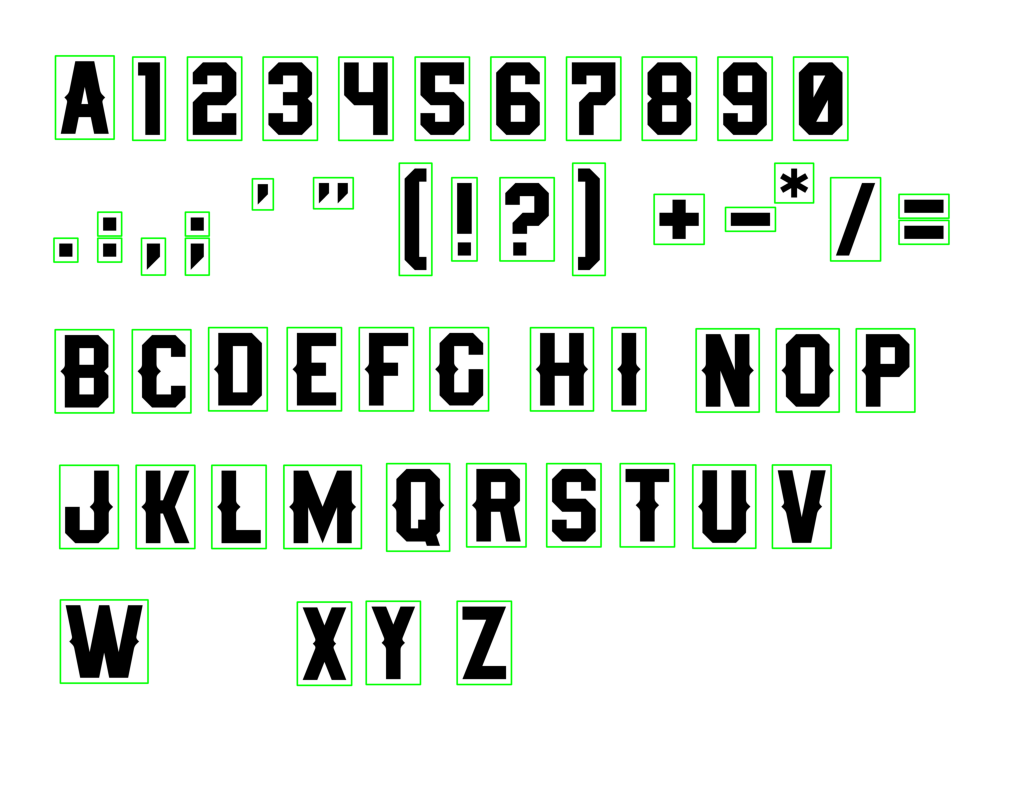

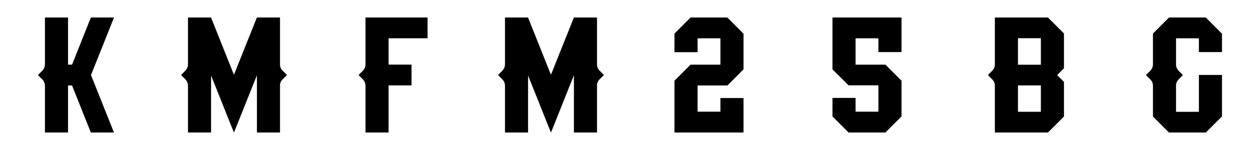

 Название шрифта:  Alumni Sans Collegiate One Italic 


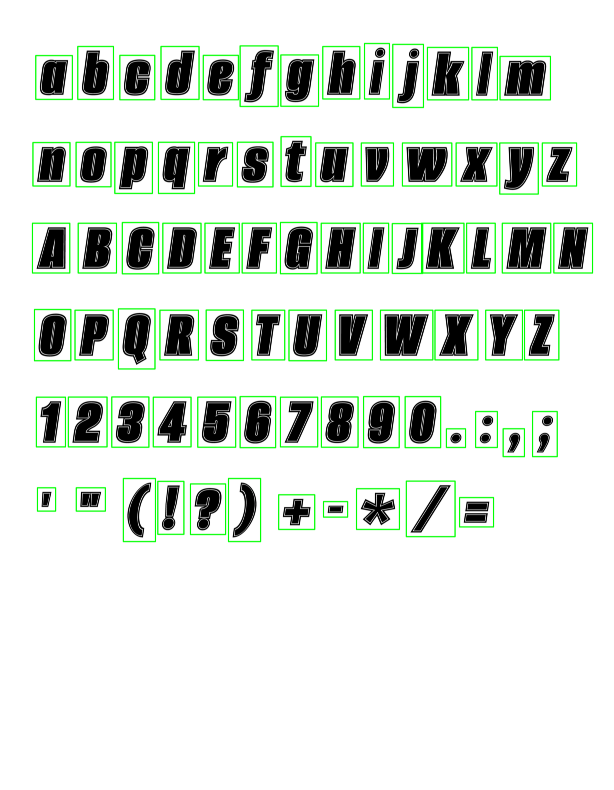

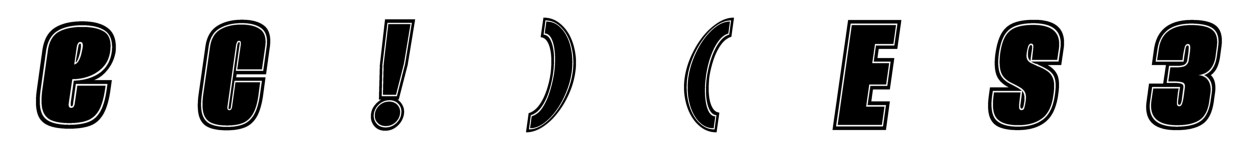

 Название шрифта:  Alumni Sans Collegiate One Regular 


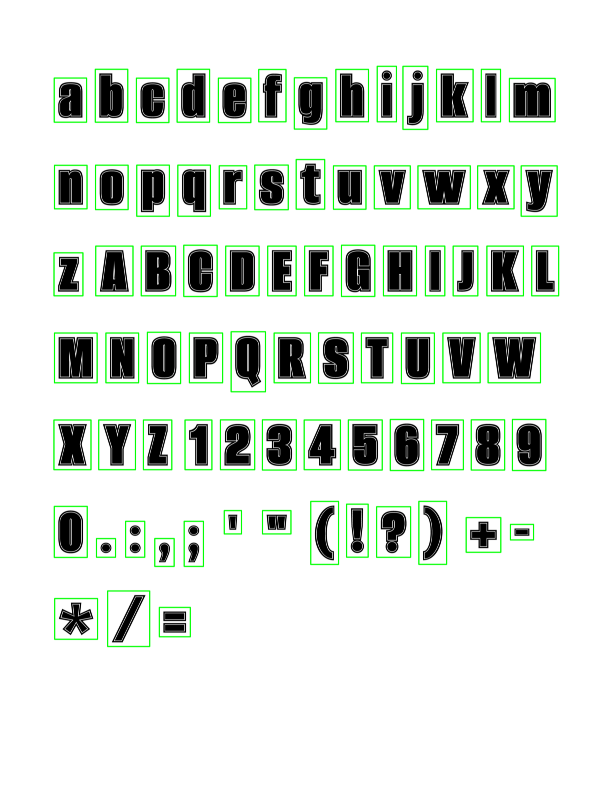

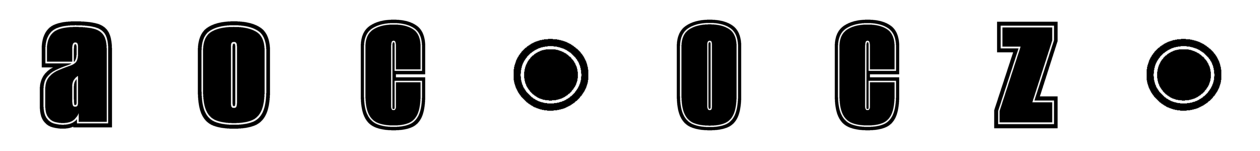

 Название шрифта:  Ambidexter 


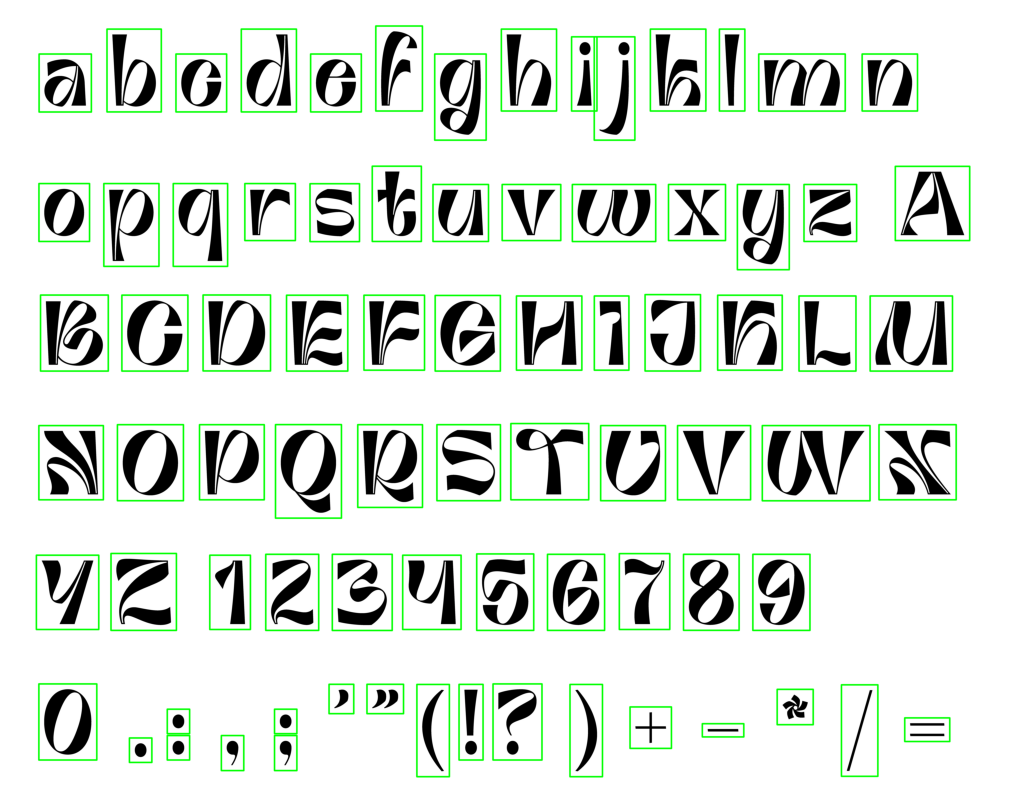

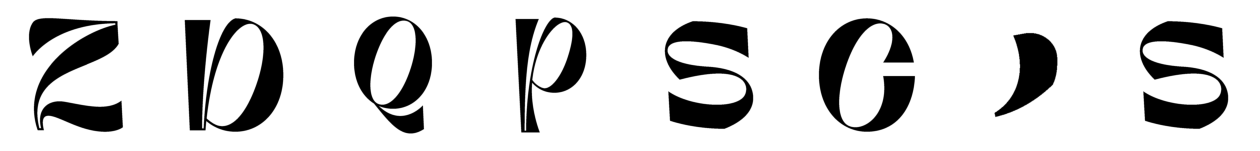

 Название шрифта:  Aref Ruqaa Ink Bold 


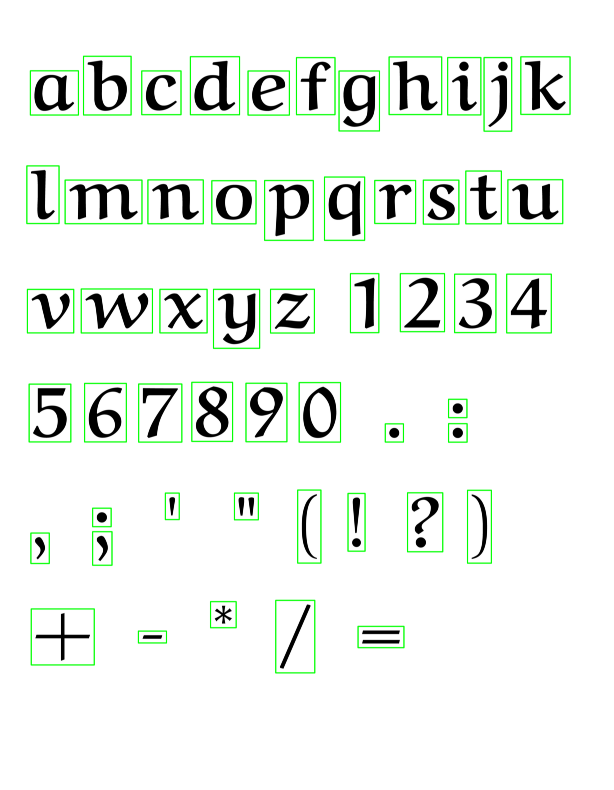

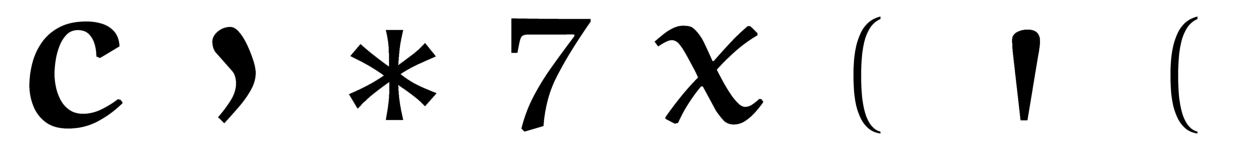

 Название шрифта:  Aref Ruqaa Ink Regular 


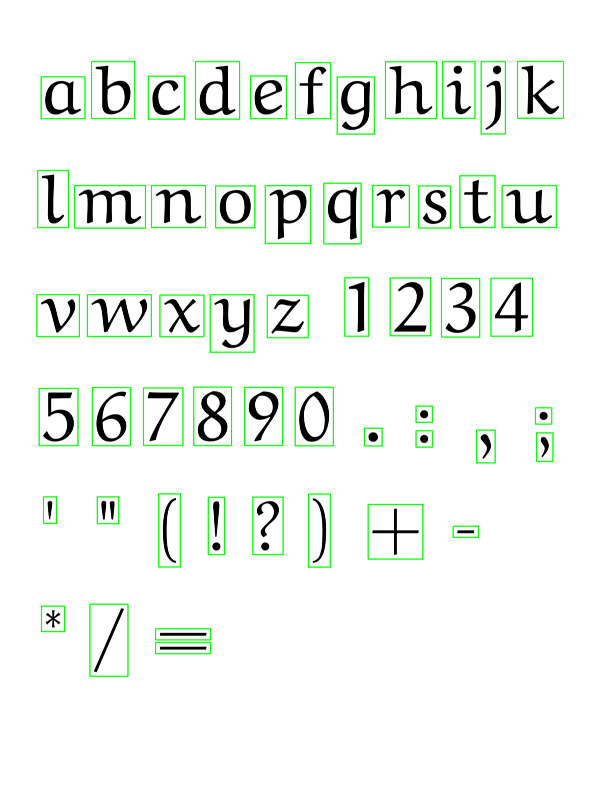

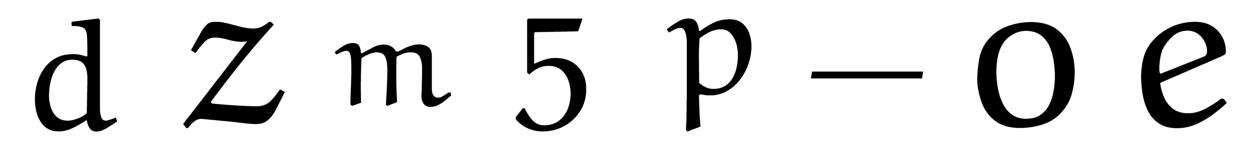

 Название шрифта:  BRASS MONO Bold 


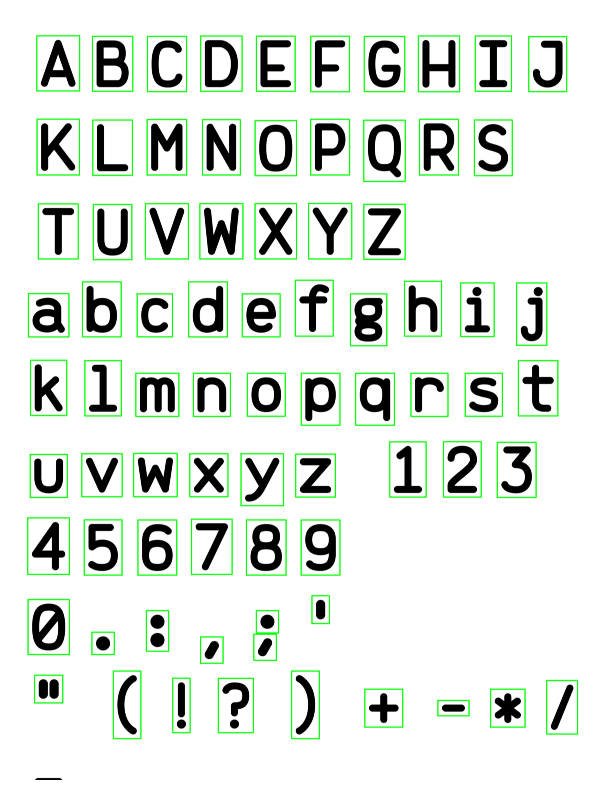

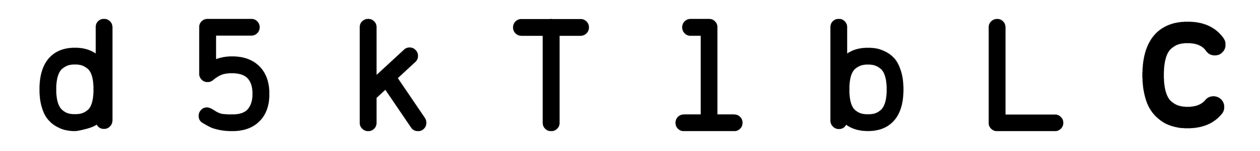

 Название шрифта:  BRASS MONO Bold Italic 


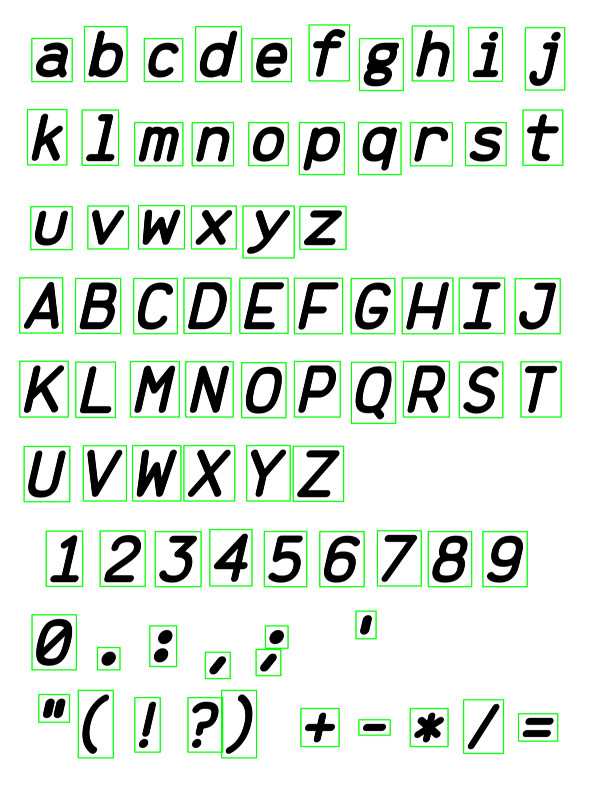

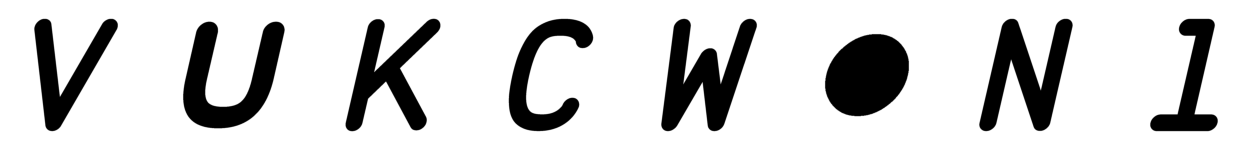

 Название шрифта:  BRASS MONO Bold Regular 


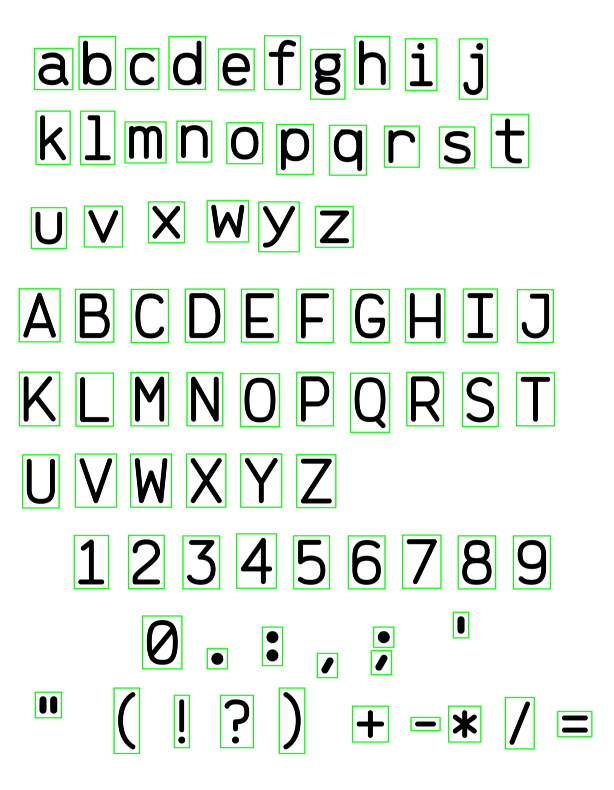

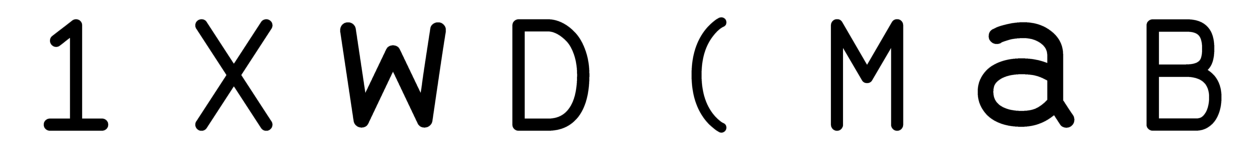

 Название шрифта:  BRASS MONO Italic 


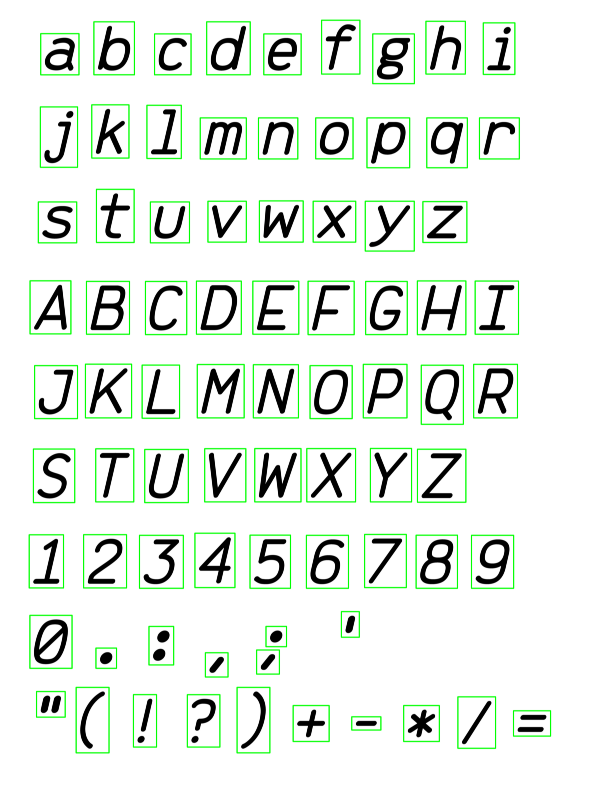

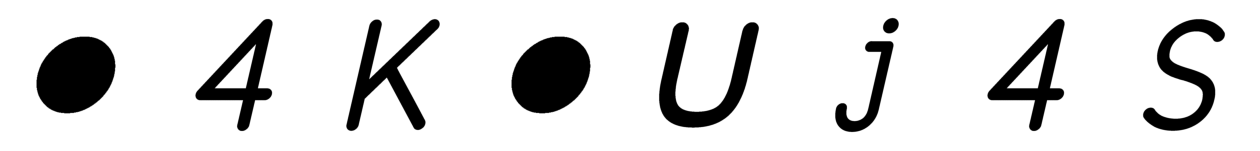

 Название шрифта:  Better VCR 5.2 


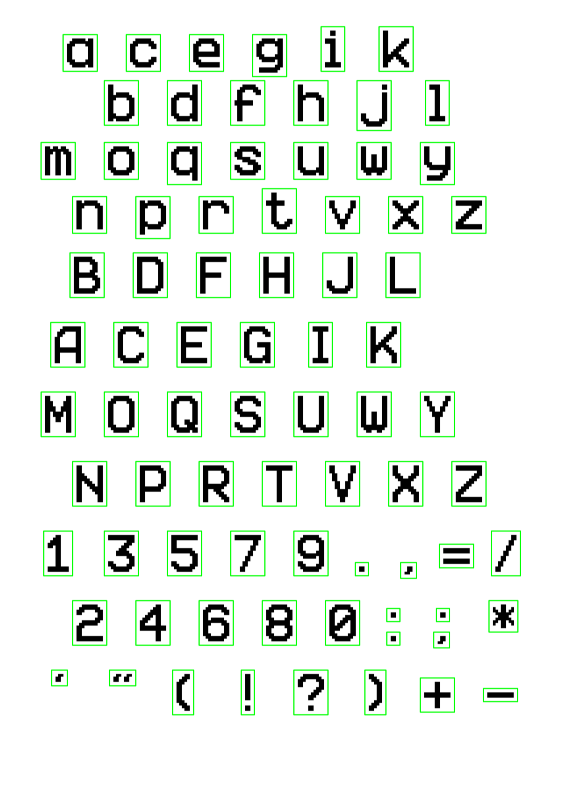

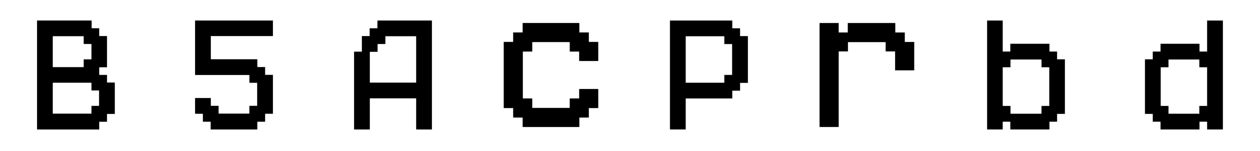

 Название шрифта:  Ganesha Type Regular 


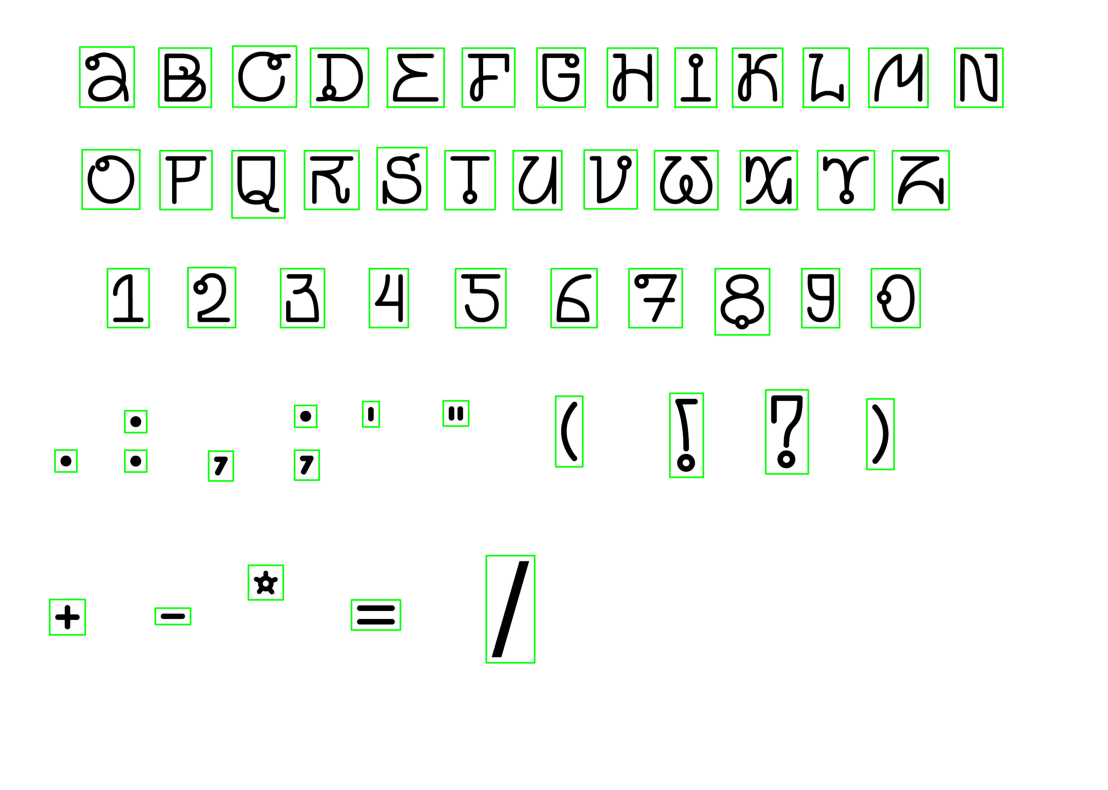

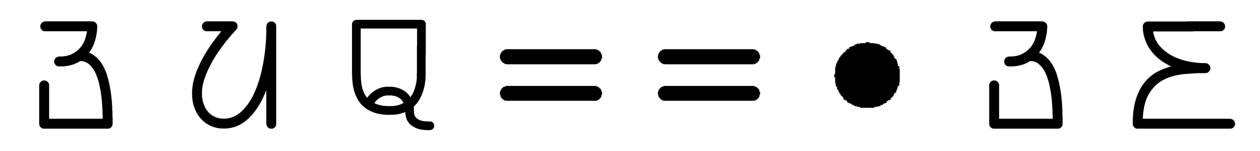

 Название шрифта:  Ghastly Panic 


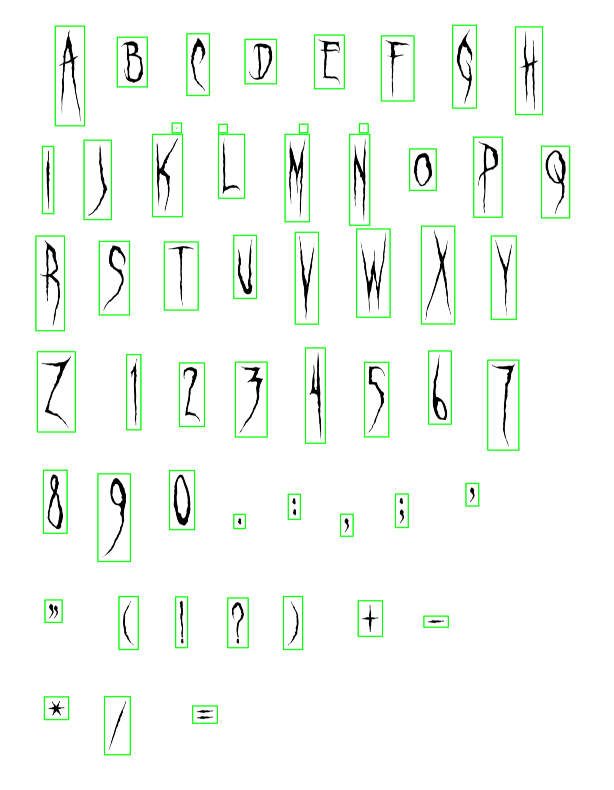

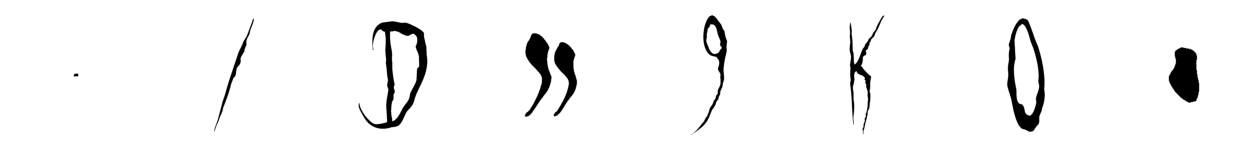

 Название шрифта:  Realest Extended 


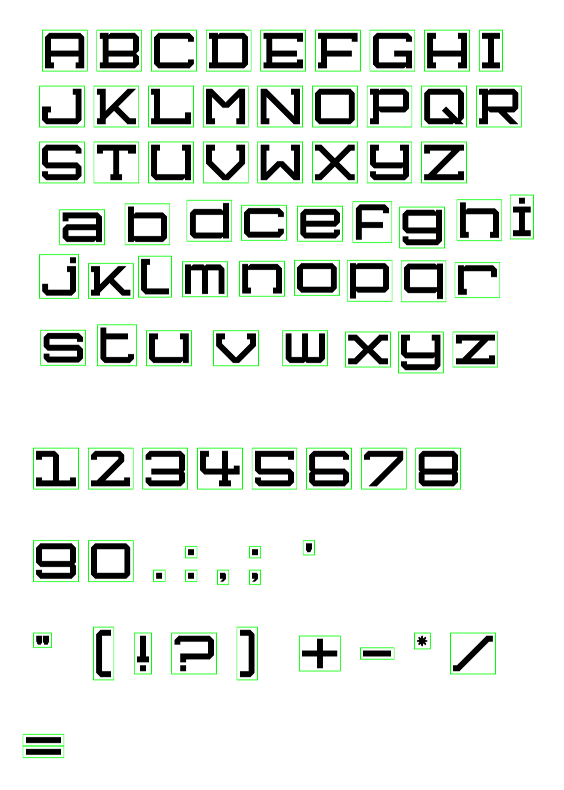

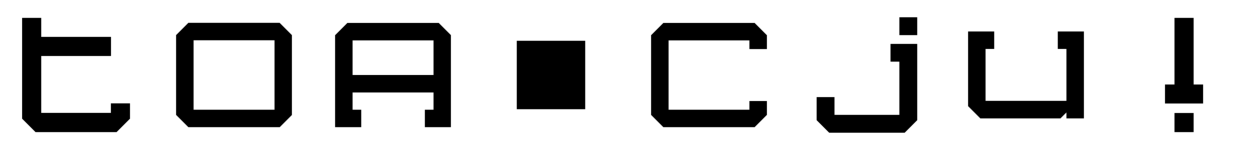

 Название шрифта:  Tana Uncial SP 


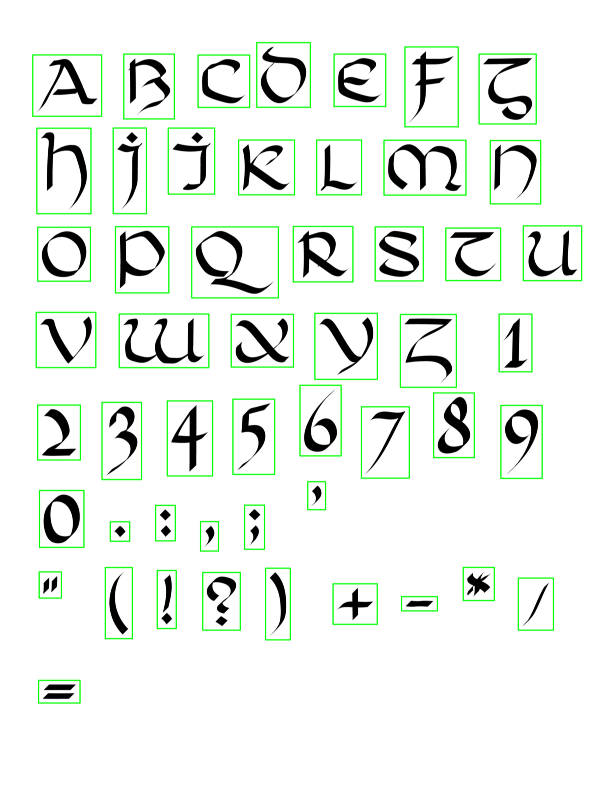

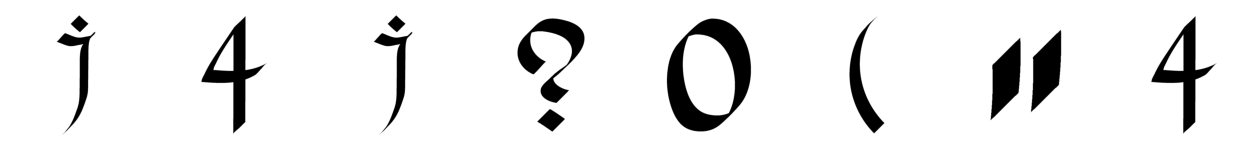

In [8]:
for k in sorted(fonts_sample):
    print('\u001b[38;5;19m', 'Название шрифта: ', k,'\u001b[0m')
    a = sample(k)
    letters_sample(a)

In [9]:
df_fonts.to_csv ('df_fonts.csv', index= False )

**В папке `fonts_sample_img` собрали выборку изображений букв наших шрифтов. Соответственно в файле `df_fonts.csv` в двух колонках собрали данные с пронумерованным именем файла изображения буквы и в другой колонке соответствующей ей название шрифта.**

In [10]:
w = 0
h = 0
for i in range(1, len(df_fonts)+1):

    image_path = 'fonts_sample_img/'+str(i)+'.jpg'
    img = Image.open(image_path)

    width, height = img.size
    if w < width:
        w = width
    if h < height:
        h = height

print('\u001b[38;5;19m', 'Максимальный размер получаяемых картинок', w, 'пикселей в ширину и', h, 'пикселей в высоту', '\u001b[0m')

 Максимальный размер получаяемых картинок 1709 пикселей в ширину и 1709 пикселей в высоту 


**Исследование показало, что полученное изображения букв и символов имеют разные размеры. Для корректного обучения нейронной сети необходимо привести все размеры изображений к одному значению. Приведем размер всех получаемых картинок к значению 256 на 256 пикселей. Повысим резкость изображения использовав фильтр `ImageFilter.SHARPEN`**

In [11]:
for i in range(1, len(df_fonts)+1):
    
    image_path = 'fonts_sample_img/'+str(i)+'.jpg'   
    img = Image.open(image_path)
    
    fixed_len = 256
    width, height = img.size
    width = img.size[0] 
    height = img.size[1] 
    if width >= height:
        ratio = (fixed_len+1)/float(img.size[0])
        new_height = int(ratio * img.size[1])
        new_size = (fixed_len+1, new_height)
    else:
        ratio = (fixed_len+1)/float(img.size[1])
        new_width = int(ratio * img.size[0])
        new_size = (new_width, fixed_len+1)
    new_image = img.resize(new_size)
    
    sharp_image = new_image.filter(ImageFilter.SHARPEN)
    image = sharp_image.resize((fixed_len, fixed_len))

    image.save(image_path)

**Учитывая, что ранее мы считывали картинки в цветном цветовом пространстве `RGB`, будем далее работать с получаемыми картинками в оттенках серого.**

In [12]:
for i in range(1, len(df_fonts)+1):
    image_path = 'fonts_sample_img/'+str(i)+'.jpg'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cv2.imwrite('fonts_sample_img/'+str(i)+'.jpg', img)

**Выведем выборку полученного результата и убедимся в качестве проведенной работы.**

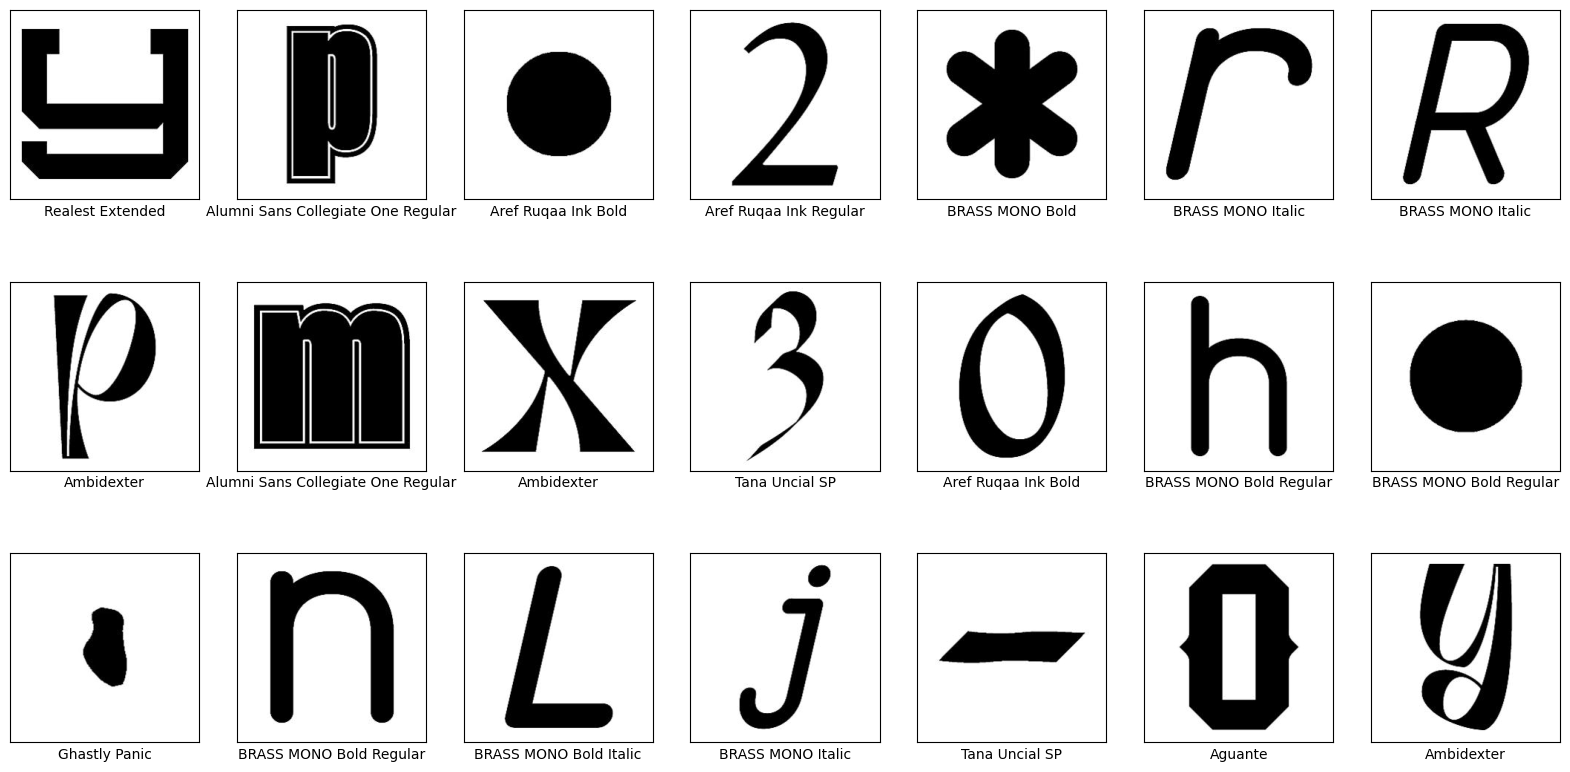

In [13]:
labels = list(df_fonts['Font'])
plt.figure(figsize=(20,10))
for i in range(21):
    num = random.randint(1, len(df_fonts))
    image_path = 'fonts_sample_img/'+str(num)+'.jpg'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.xlabel(labels[num])